# Image classification with MNIST data, with visualization of the results

This notebook shows how to train a convolutional image recognition network for recognizing hand-written digits. This is the "hello world" example of deep learning, and later on we will also have some artistic use for it. 

**Learning goals:**
* Building a simple convolutional neural network
* Useful debugging skills: visualizing errors, visualizing neural network weights

**After you've read, run, and understood the code, try to modify it as follows to test your learning:**

* Easy: Pass in an artificial image and check what class it is classified into. Hint: you can "paint" rectancles by first creating an empty single image batch as ```image=np.zeros([1,28,28,1])```, and then setting rectangular patches to 1 as ```image[0,y0:y1,x0:x1,0]=1```, where x0,x1,y0,y1 are the rectangle corners. Feel free to also explore more sophisticated drawing methods, e.g., from the skimage library. 
* Easy: Visualize the test image(s) that give(s) the largest loss function value. Hint: if you pass multiple test images to model.predict(), you will get a batch of probabilities back, one vector of 10 probabilities for each image.
* A bit harder: Try using a fully connected network instead. In this case, you need to reshape or flatten the data right at the start, and only use Keras dense layers. How much does the accuracy suffer? What do the learned network weights look like? Note: the first layer's weights are 28*28=784 long vectors, which you can reshape to 28x24 pixel images for visualization. 
* Harder: Visualize how well the network learns features that make the number classes separate. Use principal component analysis (PCA) of the flattened layer outputs, and make a 2D scatterplot of each input image's projection into the 2D subspace defined by the first two principal axes. Numpy provides easy helpers for PCA, just google it up. Do the same for all network outputs; you should see that the classes overlap less and less as the images pass through the network.

As usual, model solutions are provided for the easy exercises, but please try to think of this as a puzzle game where you first try to solve the puzzles yourself and only check out the walkthrough if necessary.

## Loading and visualizing the data

First, let's load the dataset using keras helpers and visualize some images using pyplot

c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.BNVRK7633HSX7YVO2TADGR4A5KEKXJAW.gfortran-win_amd64.dll
c:\CondaEnvs\tensorflow2\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


Populating the interactive namespace from numpy and matplotlib
shape:  (60000, 28, 28)
new shape:  (60000, 28, 28, 1)


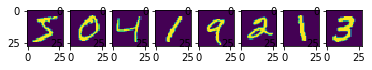

In [1]:
#The pylab inline below is something you may need to make images and plots visible in Jupyter, depending on your Anaconda setup
%pylab inline  
import numpy as np
import matplotlib.pyplot as pp
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" #disable Tensorflow GPU usage, a simple example like this runs faster on CPU
import tensorflow as tf
import tensorflow.keras as keras
#from tensorflow import keras 

#load the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

#Scale the pixel intensity values to 0...1 from 0...255
#Fortunately, we don't a StandardScaler here
x_train, x_test = x_train / 255.0, x_test / 255.0

#check the shape: you should see that x_train is a 3D tensor, 
#with 60000 instances of 2D tensors 28x28 pixels 
print("shape: ",x_train.shape)

#because the keras layers we will use need explicitly defined pixel channel count as the fourth dimension,
#we reshape:
x_train=np.reshape(x_train,[x_train.shape[0],x_train.shape[1],x_train.shape[2],1])
print("new shape: ",x_train.shape)

#do the same for test data
x_test=np.reshape(x_test,[x_test.shape[0],x_test.shape[1],x_test.shape[2],1])


#visualize some of the images
pp.figure(1)
for i in range(8):
    pp.subplot(1,8,1+i)
    #imshow expects a 2d tensor, thus we pick the i:th image, full width and height, and the first and only color channel
    pp.imshow(x_train[i,:,:,0])


## A simple convolutional neural network using Keras

Below, a brief example of how one can do the classification in Keras. However, this doesn't provide us access to things we will need for the modifications, and we'll later rebuild the network a bit differently. The code below is provided just for pedagogical purposes, as this is the way you've used Keras in the previous examples.

In [2]:
#Let's import the layer types we need
#import tensorflow.keras.layers.Layer
from tensorflow.keras.layers import Dense   #fully connected layer
from tensorflow.keras.layers import Conv2D  #convolutional layer with 2D filters (for audio you would use 1D)
from tensorflow.keras.layers import Flatten #converts images to plain vectors of numbers
from tensorflow.keras.layers import Dropout #this mitigates overfitting

#As before, we use a simply sequential, i.e., multilayer architecture
model = keras.models.Sequential()

#Instead of using fully connected layers like before, we use convolutional ones.
#We use 5x5 pixel features, and use strides of 2x2 to drop resolution by a factor of 2 after each layer
model.add(Conv2D(16, kernel_size=(5, 5), strides=[2,2],
                 activation='relu',
                 input_shape=(28,28,1,)))
model.add(Conv2D(32, (5, 5), activation='relu', strides=[2,2]))
#After the previous two layers, we are at 7x7 pixel resolution instead of the original 28x28 pixels.
#Thus, 5x5 filters would not be meaningful, as they would encompass almost the whole images
model.add(Conv2D(32, (3, 3), activation='relu', strides=[2,2]))
#Now, we are at 3x3 pixel resolution and there's no point in doing convolutions anymore.
#We will simply convert the images to arrays of 9 values (but with 32 channels, as the previous layer has 32 filters)
model.add(Flatten())
#Some regularization, typically, this is added towards the end of the model
model.add(Dropout(0.5))
#One fully connected
model.add(Dense(32, activation='relu'))
#More regularization
model.add(Dropout(0.5))
#Last fully connected layer, with softmax activation, which is what one needs for classification.
#Softmax means that each output neuron can be thought as the probability of a class.
#We use 10 neurons because MNIST has 10 classes.
model.add(Dense(10, activation='softmax'))

#Compile the model. We use sparse_categorical_crossentropy loss instead of categorica_crossentropy,
#because the label data contains indices instead of one-hot vectors
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

#Train the network
model.fit(x_train, y_train,
          batch_size=32,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 11s 185us/sample - loss: 0.9289 - acc: 0.6907 - val_loss: 0.1892 - val_acc: 0.9516

Let's test the classifier with an images. 

Testing with image:


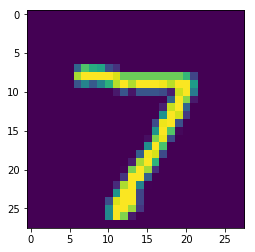

Predicted class probabilities:  [[1.1415542e-07 1.9332926e-08 7.6878378e-06 5.1005793e-07 2.9903169e-09
  6.3758304e-10 3.4856476e-13 9.9996126e-01 2.5649183e-07 3.0216619e-05]]
Most probable class is 7, with probability 0.999961256980896


In [3]:
#this is the test image
testIdx=0
#Show the image
print("Testing with image:")
pp.imshow(x_test[testIdx,:,:,0])
pp.show()
#We index by testIdx:testIdx+1 to pass a batch of one image to the network instead of just one image
classProbabilities=model.predict(x_test[testIdx:testIdx+1])
print("Predicted class probabilities: ",classProbabilities)
#np.argmax returns the index of the largest value in a Numpy tensor.
#np.max returns the largest value
print("Most probable class is {}, with probability {}".format(np.argmax(classProbabilities),np.max(classProbabilities)))


Now, let's try to see what the network has learned. Research shows that the first layer of a convolutional image classification network should learn something like detectors for oriented edges or similar simple features.

Visualizing layer 0 kernel, shape (5, 5, 1, 16)


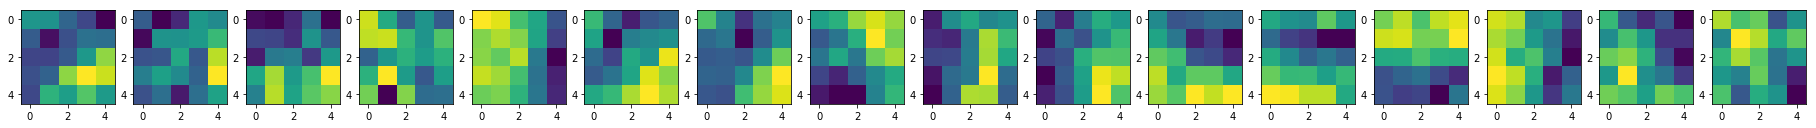

In [5]:
#Define a visualization helper

def visualizeLayerWeights(model,layerIndex):
    #Get the neuron weights, i.e., convolution kernels or filters
    kernel=model.layers[layerIndex].get_weights()[0]
    #Check the shape
    print("Visualizing layer {} kernel, shape {}".format(layerIndex,kernel.shape))
    #Visualize 16 first filters
    nFiltersToVisualize=16
    pp.figure(1,figsize=[nFiltersToVisualize*2,2])  #specify figsize explicitly because otherwise the images will be too small
    for i in range(nFiltersToVisualize):
        pp.subplot(1,nFiltersToVisualize,1+i)
        pp.imshow(kernel[:,:,0,i])
    pp.show()
    
#visualize first layer
visualizeLayerWeights(model,0)
        
